<a href="https://colab.research.google.com/github/liamchalcroft/RectAngle/blob/main/colab_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for basic prototyping of work before porting to full script for testing

Note: Try importing lambda layer

In [1]:
! git clone https://49064dc98b2d46c3874378ed4375bf1b5938d905@github.com/liamchalcroft/RectAngle.git

Cloning into 'RectAngle'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 17 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [2]:
! python ./RectAngle/data.py

Done.
Image and label data downloaded: dataset70-200.h5
  with 200 cases with a total of 5346 frames and 16038 labels.

How many example frames would you like to visualise, e.g. 10?
0


In [140]:
import h5py
import matplotlib.pyplot as plt
from torch import nn, einsum
import torch
import random
import numpy as np
from scipy.ndimage import measurements, gaussian_filter

In [4]:
f = h5py.File('dataset70-200.h5', 'r')

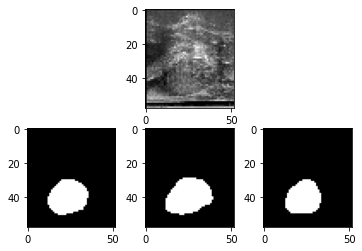

In [5]:
plt.figure()
plt.subplot(2,3,2)
plt.imshow(f['frame_0004_005'], cmap='gray')
plt.subplot(2,3,4)
plt.imshow(f['label_0004_005_00'], cmap='gray')
plt.subplot(2,3,5)
plt.imshow(f['label_0004_005_01'], cmap='gray')
plt.subplot(2,3,6)
plt.imshow(f['label_0004_005_02'], cmap='gray')
plt.show()

In [141]:
# Network stuff

class UNetBlock(nn.Module):
  def __init__(self, ch_in, n_feat, device='cpu'):

    super().__init__()

    self.conv1 = torch.nn.Sequential(
        nn.Conv2d(in_channels=ch_in, out_channels=n_feat, 
                  kernel_size=3, padding=1).to(device),
        nn.ReLU(inplace=True).to(device),
        nn.BatchNorm2d(num_features=n_feat).to(device))
    
    self.conv2 = torch.nn.Sequential(
        nn.Conv2d(in_channels=n_feat, out_channels=n_feat, 
                  kernel_size=3, padding=1).to(device),
        nn.ReLU(inplace=True).to(device),
        nn.BatchNorm2d(num_features=n_feat).to(device)
        )
    
    self.conv1.to(device)
    self.conv2.to(device)
    

  def forward(self, x):
    x = self.conv1(x)
    x = x + self.conv2(x)
    return x


class AttentionGate(nn.Module):
  # https://arxiv.org/pdf/1804.03999.pdf
  def __init__(self, encoder_channels, 
               decoder_channels, intermediate_channels):
    
    super().__init__()

    self.gate_weight = nn.Sequential(
        nn.Conv2d(decoder_channels, intermediate_channels, kernel_size=1),
        nn.BatchNorm2d(intermediate_channels)
    )

    self.activation_weight = nn.Sequential(
        nn.Conv2d(encoder_channels_channels, intermediate_channels, kernel_size=1),
        nn.BatchNorm2d(intermediate_channels)
    )

    self.relu = nn.ReLU(inplace=True)

    self.psi = nn.Sequential(
        nn.Conv2d(intermediate_channels, 1, kernel_size=1),
        nn.BatchNorm2d(1),
        nn.Sigmoid()
    )

  def forward(self, x_enc, x_dec):
    g = self.gate_weight(x_dec)
    x = self.activation_weight(x_enc)
    x = self.relu(x + g)
    x = self.psi(x)
    return x * x_enc


# class LambdaGate(nn.Module):
#   # https://arxiv.org/pdf/2102.08602.pdf
#   def __init__(self, ):


class UNet(nn.Module):
  def __init__(self, device='cpu', ch_in=1, ch_out=1,
               first_layer=16, n_layers=4, 
               gate=None):
    
    # TODO: Add options for attention/lambda gating before concat
    
    super().__init__()

    self.device = device

    self.attn_list = None

    if gate == 'attention':
      attn_list = []
      self.attn_list = attn_list
    
    enc_list = []
    down_list = []

    enc_list.append(UNetBlock(ch_in, first_layer, device).to(device))
    if self.attn_list:
      attn_list.append(AttentionGate(first_layer, first_layer*2, 
                                    first_layer*2).to(device))
    down_list.append(nn.MaxPool2d(kernel_size=2, stride=2).to(device))

    for i in range(n_layers-1):
      enc_list.append(UNetBlock(first_layer*(2**i), 
                                          first_layer*(2**(i+1)),
                                     device).to(device))
      if self.attn_list:
        attn_list.append(AttentionGate(first_layer*(2**i), 
                                       first_layer*(2**(i+1)), 
                                       first_layer*(2**(i+1))).to(device))
      down_list.append(nn.MaxPool2d(kernel_size=2, stride=2).to(device))

    self.enc_list = nn.ModuleList(enc_list)
    if self.attn_list:
      self.attn_list = nn.ModuleList(attn_list)
    self.down_list = nn.ModuleList(down_list)
      
    self.bottleneck = UNetBlock(first_layer*(2**(n_layers-1)),
                                     first_layer*(2**(n_layers)),
                                     device).to(device)

    dec_list = []
    up_list = []

    for i in range(n_layers):
      up_list.append(nn.ConvTranspose2d(first_layer*(2**(n_layers-(i))), 
                                        first_layer*(2**(n_layers-(i+1))), 
                                        kernel_size=2, stride=2).to(device))
      dec_list.append(UNetBlock(first_layer*(2**(n_layers-(i))), 
                                     first_layer*(2**(n_layers-(i+1))),
                                     device).to(device))
      
    self.dec_list = nn.ModuleList(dec_list)
    self.up_list = nn.ModuleList(up_list)
      
    self.head = nn.Conv2d(in_channels=first_layer, out_channels=ch_out, 
                          kernel_size=1).to(device)
    
    self.enc_list.to(device)
    if self.attn_list:
      self.attn_list.to(device)
    self.down_list.to(device)
    self.bottleneck.to(device)
    self.dec_list.to(device)
    self.up_list.to(device)
    self.head.to(device)
    
    
  def forward(self, x):
    # pad images to (64,64)
    shape = list(x.shape)
    shape[2] = shape[3] = 64
    pad_x = torch.zeros(shape)
    pad_x[:,:,:58,:52] = x
    x = pad_x.to(self.device)

    enc_features = []

    for i in range(len(self.enc_list)):
      x = self.enc_list[i](x)
      enc_features.append(x)
      x = self.down_list[i](x)
    
    x = self.bottleneck(x)

    enc_features = enc_features[::-1]

    for i in range(len(self.dec_list)):
      if self.attn_list:
        atnn_enc = self.attn_list[i](enc_features[i], x)
      x = self.up_list[i](x)
      if self.attn_list:
        x = torch.cat((x, attn_enc), dim=1)
      else:
        x = torch.cat((x, enc_features[i]), dim=1)
      x = self.dec_list[i](x)

    x = self.head(x)

    # crop to original size of (58,52)
    x = x[:,:,:58,:52]
    
    return torch.sigmoid(x)


In [295]:
# Loss function

class DiceLoss(nn.Module):
    # Standard Dice loss, with variable smoothing constant
    def __init__(self, soft=True, smooth=1, threshold=0.5):
        super().__init__()
        self.smooth = smooth
        self.soft = soft
        self.threshold = threshold

    def forward(self, inputs, targets):
      # Assume already in int form - binarise function available
      # Seems to perform very well without binary - soft dice?

      if not self.soft:
        inputs = BinaryDice(inputs, self.threshold)

      inputs = inputs.view(-1)
      targets = targets.view(-1)

      intersection = torch.sum(inputs * targets)
      dice = ((2. * intersection) + self.smooth) / \
              (torch.sum(inputs) + torch.sum(targets) + self.smooth)

      return (1 - dice)

    @staticmethod
    def BinaryDice(image, threshold=0.5):
      return (image > threshold).int()


In [261]:
# Pre- and post- processing:
#   * Augmentation:
#     - Noise (speckle and gauss)
#     - Smoothing (gauss only, savitzky-golay in TODO)
#     - Flip (L-R only)
#   * Post-processing:
#     - Binarise (variable threshold)
#     - Keep-largest-connected-component


def SpeckleNoise(image, type='speckle', mean=0, sigma=1, prob=0.7):
  rand_ = random.uniform(0,1)
  if rand_ < prob:
    max = torch.amax(image, dim=(1,2,3))
    noise = torch.randn(image.shape)

    for i, max_ in enumerate(max):
      mean_ = max_ * mean
      sigma_ = max_ * sigma
      noise[i,...] = mean_ + (sigma_**0.5) * noise[i,...]

    if 'speckle':
      return noise * image
    elif 'gauss':
      return noise + image
    else:
      raise ValueError('Invalid noise type - \
      please enter either "speckle" or "gauss".')
  

def Smooth(image, sigma=1, prob=0.7):
  # Ideally add Savitzky-Golay filter instead of Gauss
  rand_ = random.uniform(0,1)
  if rand_ < prob:
    max = torch.amax(image, dim=(1,2,3))
    noise = torch.randn(image.shape)

    for i, max_ in enumerate(max):
      sigma_ = max_ * sigma_
      image_ = torch.squeeze(image[i,0,...])
      image_ = image_.detach().cpu().numpy()
      image_smooth_ = gaussian_filter(image_, sigma_)
      image[i,0,...] = torch.tensor(image_smooth_)
    return image


def Flip(image, prob=0.7):
  rand_ = random.uniform(0,1)
  if rand_ < prob:
    return torch.fliplr(image)


def KeepLargestComponent(image):
  # FIX: Currently sets whole image to zero...
  image_batch_ = torch.squeeze(image, dim=1)
  image_batch_ = image_batch_.detach().cpu().numpy()
  batch_size_ = image_batch_.shape[0]

  for image_ in range(batch_size_):
    image_ = np.squeeze(image_)
    comp_, feat_ = measurements.label(image_)
    largest_ = (image_ == feat_).astype(int)
    image[image_,...] = torch.tensor(largest_)
  
  return image


def Binary(image, threshold=0.5):
  return (image > threshold).int()


In [262]:
# Data loading

def train_val_test(file, ratio=(0.6, 0.2, 0.2)):
  keys = [key.split('_') for key in file.keys()]
  num_subjects = int(keys[-1][1])
  assert 1.0 * sum(ratio) == 1.0
  sum_ratio = list(ratio)
  if sum_ratio[1] > 0:
    sum_ratio[1] += sum_ratio[0]
  if sum_ratio[2] > 0:
    sum_ratio[2] += sum_ratio[1]
  scaled_ratio = [int(round(val * num_subjects)) for val in sum_ratio]

  ix = np.linspace(0, num_subjects, num_subjects+1, dtype=int)
  train_ix = ix[:scaled_ratio[0]]
  if scaled_ratio[1] > 0:
    val_ix = ix[scaled_ratio[0]:scaled_ratio[1]]
  else:
    val_ix = 0
  if scaled_ratio[2] > 0:
    test_ix = ix[scaled_ratio[1]:scaled_ratio[2]]
  else:
    test_ix = 0

  return train_ix, val_ix, test_ix


def key_gen(file, ix):
  keys = list(file.keys())
  split_keys = [key.split('_') for key in keys]
  new_keys = []

  for i, key in enumerate(split_keys):
    if int(key[1]) in ix:
      new_keys.append(keys[i])

  return new_keys


class H5DataLoader(torch.utils.data.Dataset):
  def __init__(self, file, keys=None):
    
    super().__init__()

    self.file = file
    if not keys:
      keys = list(file.keys())
    split_keys = [key.split('_') for key in keys]
    start_subj = int(split_keys[0][1])
    last_subj = int(split_keys[-1][1])
    self.num_subjects = last_subj - start_subj
    self.subjects = np.linspace(start_subj, last_subj, 
                                self.num_subjects+1, dtype=int)
    num_frames = []
    for subj in range(start_subj, last_subj):
      subj_string = str(subj).zfill(4)
      frames = [key[2] for key in split_keys if key[1] == subj_string]
      num_frames.append(int(frames[-1]))

    self.num_frames = num_frames

  def __len__(self):
        return self.num_subjects
  
  def __getitem__(self, index):
    subj_ix = self.subjects[index]
    frame_ix = random.randint(0, self.num_frames[index])
    label_ix = random.randint(0, 2)
    image = torch.unsqueeze(torch.tensor(
        self.file['frame_%04d_%03d' % (subj_ix, 
                                       frame_ix
                                       )][()].astype('float32')), dim=0)
    label = torch.unsqueeze(torch.tensor(
        self.file['label_%04d_%03d_%02d' % (subj_ix, 
                                            frame_ix, 
                                            label_ix
                                            )][()].astype(int)), dim=0)
    return(image, label)


In [263]:
# print(model)

In [264]:
# ! pip install lambda-networks

In [265]:
# Either figure out lambda import or write from scratch based on holocron code

In [290]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  torch.backends.cudnn.benchmark = True
else:
  device = torch.device('cpu')

model = UNet(n_layers=5, device=device, gate='attention')
# model = UNet(n_layers=5, device=device, gate=None)

In [291]:
train_ix, val_ix, test_ix = train_val_test(f)

train_keys, val_keys, test_keys = key_gen(f, train_ix), \
                                  key_gen(f, val_ix),\
                                  key_gen(f, test_ix)

train_data, val_data, test_data = H5DataLoader(f, train_keys), \
                                  H5DataLoader(f, val_keys), \
                                  H5DataLoader(f, test_keys)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                           shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, 
                                         shuffle=True, num_workers=0)

print('Training data: {} subjects, Val data: {} subjects, Test data: {} subjects'.format(\
      train_data.num_subjects, val_data.num_subjects, test_data.num_subjects))

Training data: 118 subjects, Val data: 39 subjects, Test data: 39 subjects


In [292]:
dice_loss = DiceLoss(soft=True, smooth=0)

dice_val = DiceLoss(smooth=0)

optim = torch.optim.Adam(model.parameters())

In [293]:
nb_epoch = 1000
print_interval = 50
val_interval = 10

loss_epoch = []
loss_log = []
dice_log = []

In [294]:
for epoch in range(nb_epoch):
  for step, (input, label) in enumerate(train_loader):
    input, label = input.to(device), label.to(device)

    optim.zero_grad()
    pred = model(input)
    loss = dice_loss(pred, label)
    loss.backward()
    optim.step()

    loss_epoch.append(loss.item())

  mean_loss = np.mean(loss_epoch)
  loss_log.append(mean_loss)
  if epoch % print_interval == 0:
    print('Epoch #{}: Mean Dice Loss: {}'.format(epoch, mean_loss))

  if epoch % val_interval == 0:
    with torch.no_grad():
      for input, label in val_loader:
        input, label = input.to(device), label.to(device)

        pred = model(input)
        pred = Binary(pred)
        # pred = KeepLargestComponent(pred)
        dice_metric = dice_val(pred, label)
        dice_metric = 1 - dice_metric.item()

    dice_log.append(dice_metric)
    if epoch % print_interval == 0:
      print('Mean Validation Dice: {}'.format(dice_metric))

print('\nTraining Complete')

Epoch #0: Mean Dice Loss: 0.7861521244049072
Mean Validation Dice: 0.24316847324371338
Epoch #50: Mean Dice Loss: 0.3252310834678949
Mean Validation Dice: 0.6706184148788452
Epoch #100: Mean Dice Loss: 0.2571684697476944
Mean Validation Dice: 0.6547417044639587
Epoch #150: Mean Dice Loss: 0.22777330539873894
Mean Validation Dice: 0.8143209218978882
Epoch #200: Mean Dice Loss: 0.21003171920183286
Mean Validation Dice: 0.4995673894882202
Epoch #250: Mean Dice Loss: 0.19716955109896414
Mean Validation Dice: 0.5064205527305603
Epoch #300: Mean Dice Loss: 0.1879523955904368
Mean Validation Dice: 0.8026520013809204
Epoch #350: Mean Dice Loss: 0.1814292316932624
Mean Validation Dice: 0.8884490728378296
Epoch #400: Mean Dice Loss: 0.17613265884487408
Mean Validation Dice: 0.587367057800293
Epoch #450: Mean Dice Loss: 0.17180818715803903
Mean Validation Dice: 0.6764773726463318
Epoch #500: Mean Dice Loss: 0.16822556654612222
Mean Validation Dice: 0.8106654286384583
Epoch #550: Mean Dice Loss: 0

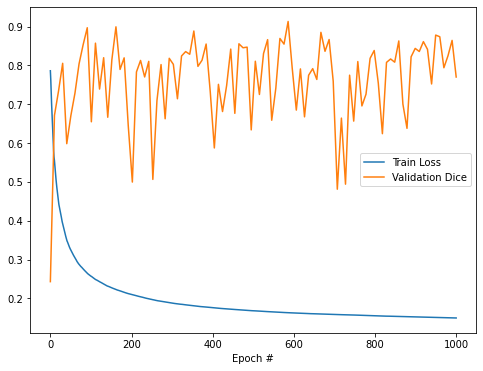

In [297]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0,nb_epoch,nb_epoch), loss_log)
plt.plot(np.linspace(0,nb_epoch,nb_epoch//val_interval), dice_log)
plt.xlabel('Epoch #')
plt.legend(['Train Loss', 'Validation Dice'])
plt.show()

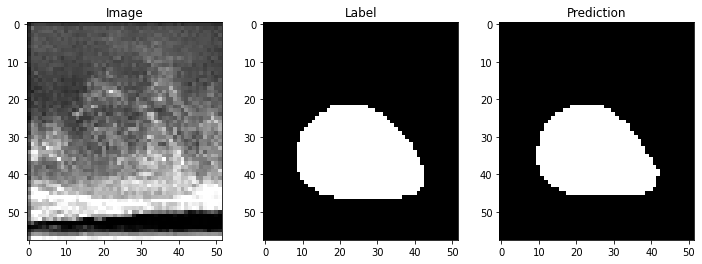

In [314]:
with torch.no_grad():
  (image, label) = next(iter(val_loader))
  image, label = image.to(device), label.to(device)
  pred = model(image)
  pred = Binary(pred, threshold=0.9)
  # pred = KeepLargestComponent(pred)
  image, label, pred = (image.detach().cpu().numpy(), 
                      label.detach().cpu().numpy(), 
                      pred.detach().cpu().numpy())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(image[0,0,:,:], cmap='gray')
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(label[0,0,:,:], cmap='gray')
plt.title('Label')
plt.subplot(1,3,3)
plt.imshow(pred[0,0,:,:], cmap='gray')
plt.title('Prediction')
plt.show()